In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score

In [2]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")


Tamaño del conjunto de entrenamiento: 120
Tamaño del conjunto de validación: 30


In [3]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNN, self).__init__()
        
        # Capa de entrada
        self.input_layer = nn.Linear(4, 10)  # 4 características de entrada y 10 neuronas en la capa oculta
        
        # Capa oculta
        self.hidden_layer = nn.Linear(10, 10)  # 10 neuronas en la capa oculta y 10 en la siguiente
        
        # Capa de salida
        self.output_layer = nn.Linear(10, 3)  # 10 neuronas en la capa oculta y 3 neuronas de salida
        
    def forward(self, x):
        # Pasar la entrada a través de la capa de entrada y luego aplicar ReLU
        x = nn.ReLU()(self.input_layer(x))
        
        # Pasar la salida anterior a través de la capa oculta y luego aplicar ReLU
        x = nn.ReLU()(self.hidden_layer(x))
        
        # Pasar la salida anterior a través de la capa de salida
        # Nota: No aplicamos Softmax aquí porque durante el entrenamiento utilizaremos
        # CrossEntropyLoss que ya aplica Softmax.
        return self.output_layer(x)
        


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = SimpleFeedForwardNN()
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss(),
    "SmoothL1Loss": nn.SmoothL1Loss()
}

def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)


for name, criterion in loss_functions.items():
    model.apply(lambda m: m.reset_parameters() if type(m) == nn.Linear else None)
    
    for epoch in range(50):
        model.train()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        test_loss = evaluate_model(model, criterion, test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}")


<generator object Module.parameters at 0x0000019D46D29000>
Epoch 1 [CrossEntropy] - Training Loss: 1.1006, Test Loss: 1.0957
Epoch 2 [CrossEntropy] - Training Loss: 1.0950, Test Loss: 1.0888
Epoch 3 [CrossEntropy] - Training Loss: 1.0865, Test Loss: 1.0819
Epoch 4 [CrossEntropy] - Training Loss: 1.0835, Test Loss: 1.0748
Epoch 5 [CrossEntropy] - Training Loss: 1.0763, Test Loss: 1.0674
Epoch 6 [CrossEntropy] - Training Loss: 1.0702, Test Loss: 1.0598
Epoch 7 [CrossEntropy] - Training Loss: 1.0635, Test Loss: 1.0520
Epoch 8 [CrossEntropy] - Training Loss: 1.0565, Test Loss: 1.0440
Epoch 9 [CrossEntropy] - Training Loss: 1.0503, Test Loss: 1.0358
Epoch 10 [CrossEntropy] - Training Loss: 1.0419, Test Loss: 1.0274
Epoch 11 [CrossEntropy] - Training Loss: 1.0346, Test Loss: 1.0185
Epoch 12 [CrossEntropy] - Training Loss: 1.0277, Test Loss: 1.0091
Epoch 13 [CrossEntropy] - Training Loss: 1.0158, Test Loss: 0.9995
Epoch 14 [CrossEntropy] - Training Loss: 1.0103, Test Loss: 0.9893
Epoch 15 [Cr

In [5]:
# Redefinimos la red neuronal con Dropout
class RegularizedFeedForwardNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(RegularizedFeedForwardNN, self).__init__()
        
        self.input_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 3)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = nn.ReLU()(self.input_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = nn.ReLU()(self.hidden_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.output_layer(x)
        return x

# L1 Regularización
def l1_penalty(model):
    return sum(torch.sum(torch.abs(p)) for p in model.parameters())

# Función de entrenamiento con regularización L1
def train_with_l1(model, criterion, optimizer, train_loader, l1_lambda):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) + l1_lambda * l1_penalty(model)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Hyperparámetros
EPOCHS = 50
L1_LAMBDA = 0.001
DROPOUT_RATE = 0.5

# Modelos con y sin regularización
models = {
    "Base Model": RegularizedFeedForwardNN(dropout_rate=0.0),
    "Dropout": RegularizedFeedForwardNN(dropout_rate=DROPOUT_RATE),
    "L1": RegularizedFeedForwardNN(dropout_rate=0.0),
    "L2": RegularizedFeedForwardNN(dropout_rate=0.0)
}

optimizers = {
    name: optim.Adam(model.parameters(), lr=0.001, weight_decay=(0.01 if name == "L2" else 0))
    for name, model in models.items()
}

for name, model in models.items():
    optimizer = optimizers[name]
    for epoch in range(EPOCHS):
        if name == "L1":
            train_loss = train_with_l1(model, nn.CrossEntropyLoss(), optimizer, train_loader, L1_LAMBDA)
        else:
            train_loss = evaluate_model(model, nn.CrossEntropyLoss(), train_loader)
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1 [Base Model] - Training Loss: 1.1753, Test Loss: 1.1915
Epoch 2 [Base Model] - Training Loss: 1.1746, Test Loss: 1.1915
Epoch 3 [Base Model] - Training Loss: 1.1787, Test Loss: 1.1915
Epoch 4 [Base Model] - Training Loss: 1.1713, Test Loss: 1.1915
Epoch 5 [Base Model] - Training Loss: 1.1730, Test Loss: 1.1915
Epoch 6 [Base Model] - Training Loss: 1.1689, Test Loss: 1.1915
Epoch 7 [Base Model] - Training Loss: 1.1753, Test Loss: 1.1915
Epoch 8 [Base Model] - Training Loss: 1.1767, Test Loss: 1.1915
Epoch 9 [Base Model] - Training Loss: 1.1769, Test Loss: 1.1915
Epoch 10 [Base Model] - Training Loss: 1.1679, Test Loss: 1.1915
Epoch 11 [Base Model] - Training Loss: 1.1745, Test Loss: 1.1915
Epoch 12 [Base Model] - Training Loss: 1.1804, Test Loss: 1.1915
Epoch 13 [Base Model] - Training Loss: 1.1755, Test Loss: 1.1915
Epoch 14 [Base Model] - Training Loss: 1.1746, Test Loss: 1.1915
Epoch 15 [Base Model] - Training Loss: 1.1762, Test Loss: 1.1915
Epoch 16 [Base Model] - Training L

In [6]:
batch_sizes = {
    "SGD": 1,
    "Batch GD": len(train_data),
    "Mini-Batch GD": 32 
}

models = {name: SimpleFeedForwardNN() for name in batch_sizes.keys()}
optimizers = {name: optim.SGD(model.parameters(), lr=0.01) for name, model in models.items()}

for name, batch_size in batch_sizes.items():
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    model = models[name]
    optimizer = optimizers[name]
    
    print(f"Training with {name}")
    
    for epoch in range(50):
        model.train()
        start_time = time.time()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        
        print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}, Time: {elapsed_time:.2f} seconds")

Training with SGD
Epoch 1 - Training Loss: 1.1450, Test Loss: 1.0893, Time: 0.09 seconds
Epoch 2 - Training Loss: 1.0819, Test Loss: 1.0327, Time: 0.09 seconds
Epoch 3 - Training Loss: 1.0072, Test Loss: 0.9282, Time: 0.09 seconds
Epoch 4 - Training Loss: 0.8783, Test Loss: 0.7833, Time: 0.08 seconds
Epoch 5 - Training Loss: 0.7485, Test Loss: 0.6801, Time: 0.08 seconds
Epoch 6 - Training Loss: 0.6662, Test Loss: 0.6212, Time: 0.09 seconds
Epoch 7 - Training Loss: 0.6115, Test Loss: 0.5769, Time: 0.09 seconds
Epoch 8 - Training Loss: 0.5748, Test Loss: 0.5476, Time: 0.09 seconds
Epoch 9 - Training Loss: 0.5460, Test Loss: 0.5238, Time: 0.08 seconds
Epoch 10 - Training Loss: 0.5215, Test Loss: 0.4999, Time: 0.08 seconds
Epoch 11 - Training Loss: 0.4999, Test Loss: 0.4778, Time: 0.08 seconds
Epoch 12 - Training Loss: 0.4762, Test Loss: 0.4519, Time: 0.11 seconds
Epoch 13 - Training Loss: 0.4477, Test Loss: 0.4193, Time: 0.10 seconds
Epoch 14 - Training Loss: 0.4114, Test Loss: 0.3717, Ti

In [12]:
iris = load_iris()
X = iris['data']
y = iris['target']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [13]:
loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss(),
    "SmoothL1Loss": nn.SmoothL1Loss()
}

regularization = {
    "None": {'weight_decay': 0.0, 'dropout': 0.0},
    "L1": {'weight_decay': 0.01, 'dropout': 0.0},
    "L2": {'weight_decay': 0.0, 'dropout': 0.5}
}

optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "Adagrad": optim.Adagrad
}

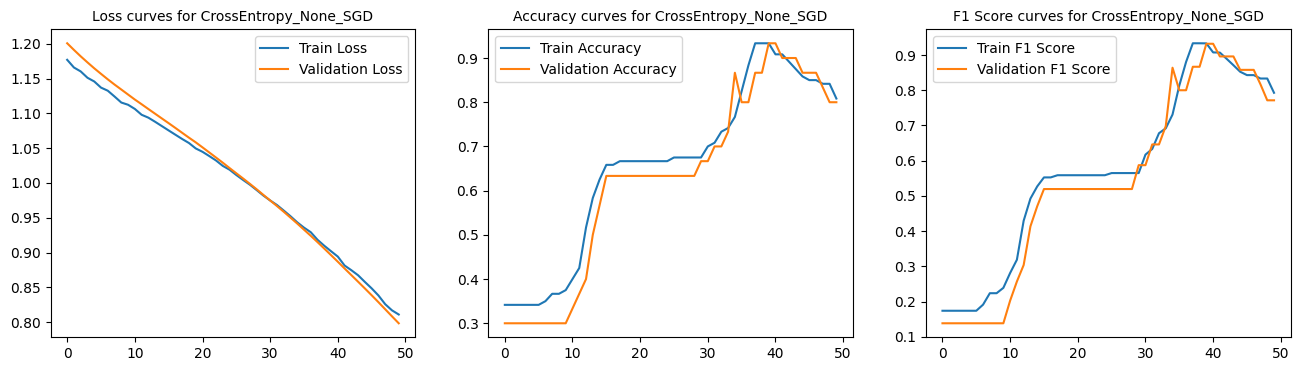

For CrossEntropy_None_SGD:
  - Training time: 2.2946 seconds
  - Final Training Accuracy: 0.8083
  - Final Validation Accuracy: 0.8000
  - Final Training F1 Score: 0.7928
  - Final Validation F1 Score: 0.7714



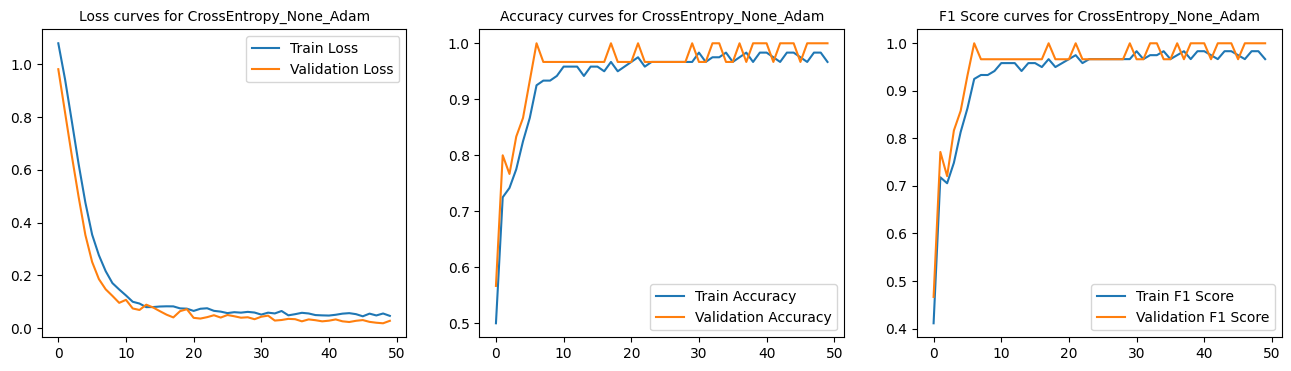

For CrossEntropy_None_Adam:
  - Training time: 2.0774 seconds
  - Final Training Accuracy: 0.9667
  - Final Validation Accuracy: 1.0000
  - Final Training F1 Score: 0.9667
  - Final Validation F1 Score: 1.0000



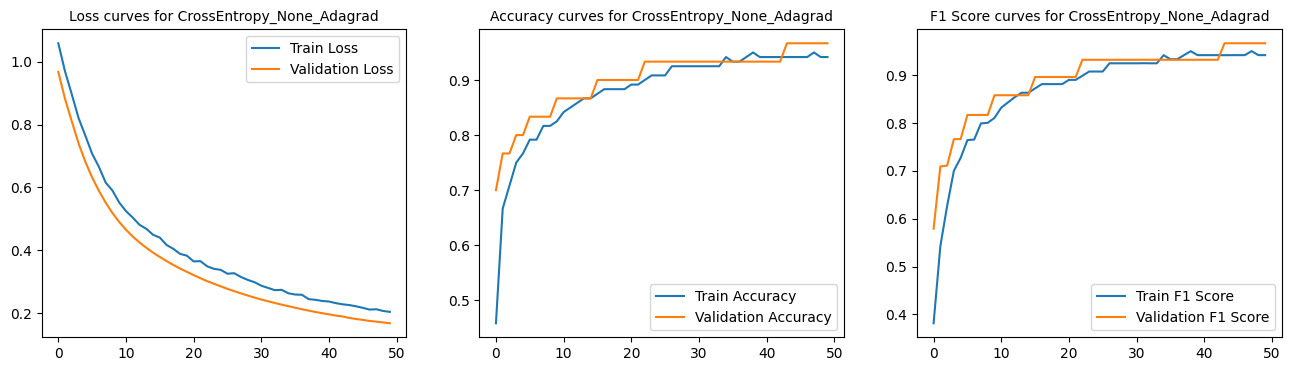

For CrossEntropy_None_Adagrad:
  - Training time: 2.2727 seconds
  - Final Training Accuracy: 0.9417
  - Final Validation Accuracy: 0.9667
  - Final Training F1 Score: 0.9416
  - Final Validation F1 Score: 0.9664



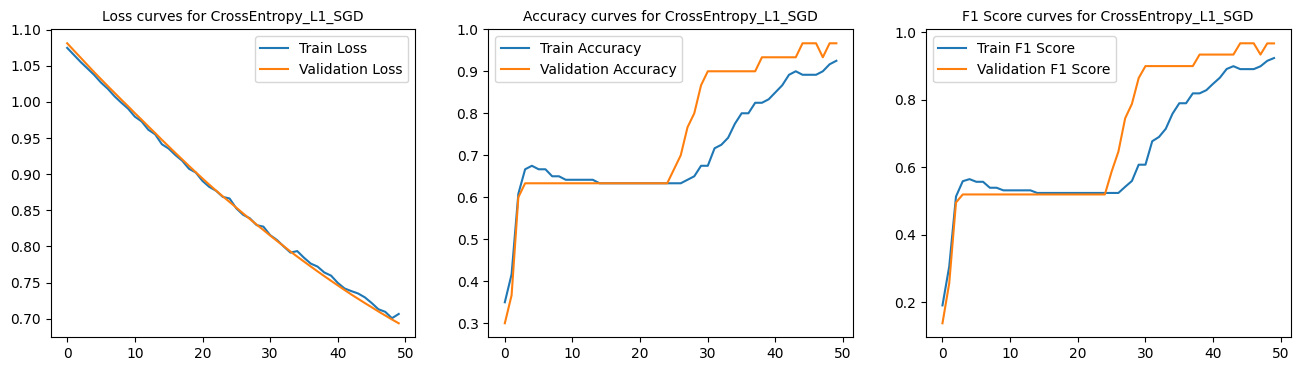

For CrossEntropy_L1_SGD:
  - Training time: 2.5112 seconds
  - Final Training Accuracy: 0.9250
  - Final Validation Accuracy: 0.9667
  - Final Training F1 Score: 0.9231
  - Final Validation F1 Score: 0.9664



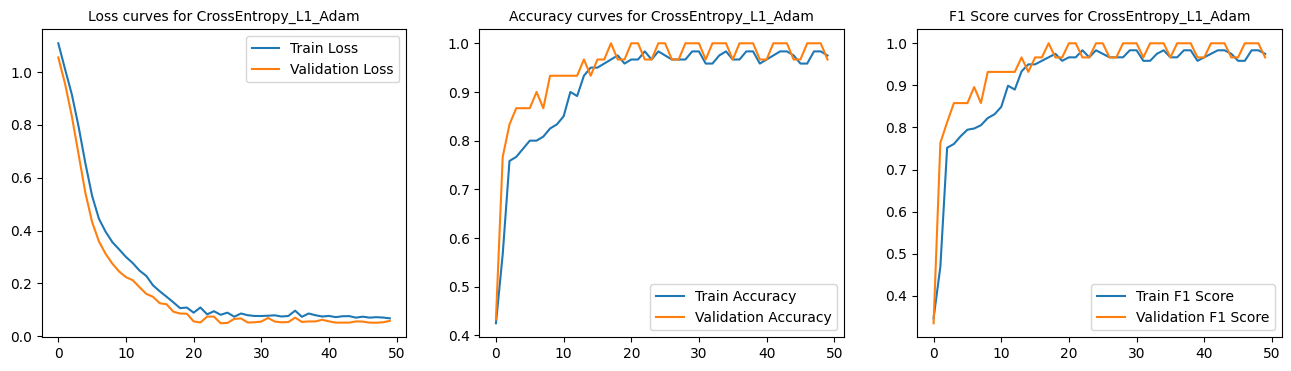

For CrossEntropy_L1_Adam:
  - Training time: 2.3901 seconds
  - Final Training Accuracy: 0.9750
  - Final Validation Accuracy: 0.9667
  - Final Training F1 Score: 0.9750
  - Final Validation F1 Score: 0.9664



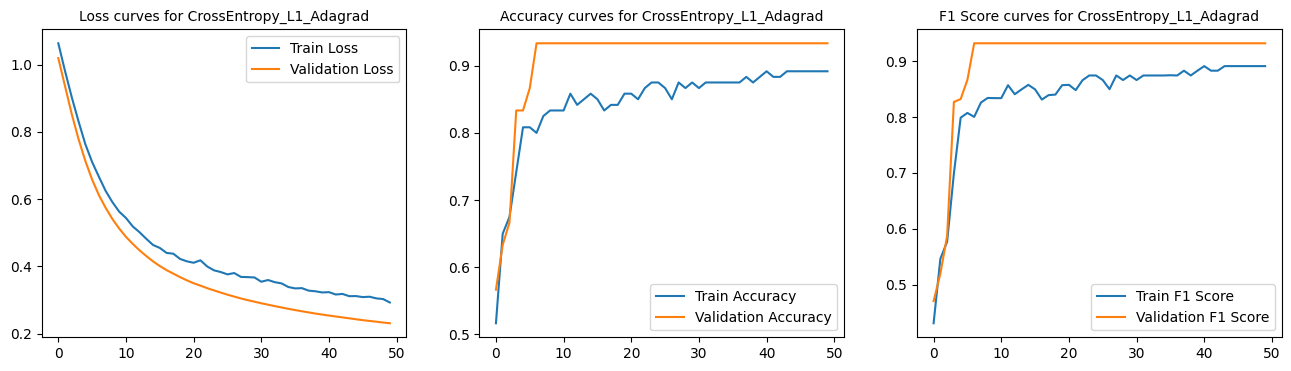

For CrossEntropy_L1_Adagrad:
  - Training time: 2.1807 seconds
  - Final Training Accuracy: 0.8917
  - Final Validation Accuracy: 0.9333
  - Final Training F1 Score: 0.8911
  - Final Validation F1 Score: 0.9319



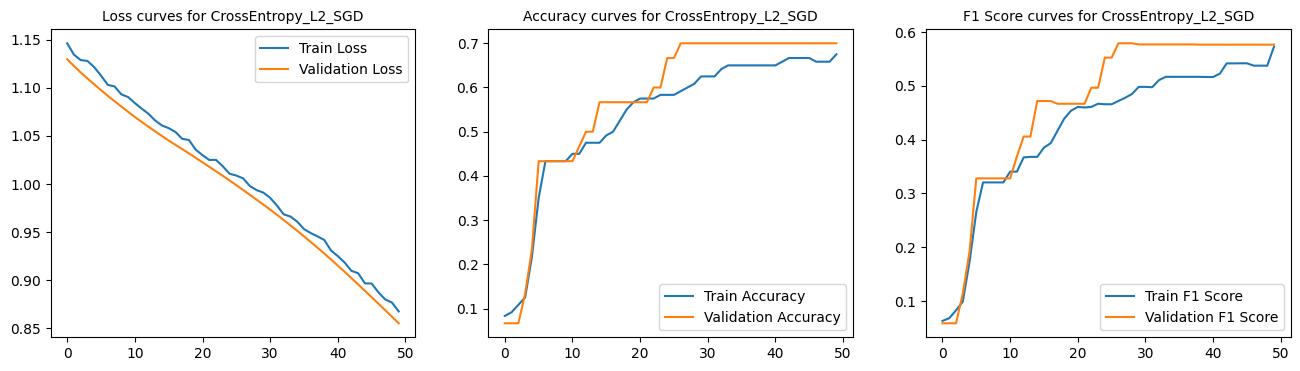

For CrossEntropy_L2_SGD:
  - Training time: 2.0598 seconds
  - Final Training Accuracy: 0.6750
  - Final Validation Accuracy: 0.7000
  - Final Training F1 Score: 0.5728
  - Final Validation F1 Score: 0.5765



KeyboardInterrupt: 

In [37]:
results = {}

for loss_name, criterion in loss_functions.items():
    for reg_name, reg_params in regularization.items():
        for opt_name, opt_class in optimizers.items():
            config_name = f"{loss_name}_{reg_name}_{opt_name}"
            model = SimpleFeedForwardNN()
            optimizer = opt_class(model.parameters(), lr=0.01, weight_decay=reg_params['weight_decay'])
            train_loss, val_loss = [], []
            train_accuracy, val_accuracy = [], []
            train_f1, val_f1 = [], []
            start_time = time.time()

            for epoch in range(50):
                model.train()
                epoch_train_loss = 0
                y_true_train, y_pred_train = [], []
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    if loss_name in ["MSELoss", "SmoothL1Loss"]:
                        criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                    else:
                        criterion_targets = targets
                    loss = criterion(outputs, criterion_targets)
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    y_true_train.extend(targets.tolist())
                    y_pred_train.extend(predicted.tolist())

                train_loss.append(epoch_train_loss / len(train_loader))
                train_accuracy.append(accuracy_score(y_true_train, y_pred_train))
                train_f1.append(f1_score(y_true_train, y_pred_train, average='weighted'))

                # Evaluación del modelo en el conjunto de validación
                model.eval()
                epoch_val_loss = 0
                y_true_val, y_pred_val = [], []
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        outputs = model(inputs)
                        if loss_name in ["MSELoss", "SmoothL1Loss"]:
                            criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                        else:
                            criterion_targets = targets
                        loss = criterion(outputs, criterion_targets)
                        epoch_val_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        y_true_val.extend(targets.tolist())
                        y_pred_val.extend(predicted.tolist())

                val_loss.append(epoch_val_loss / len(test_loader))
                val_accuracy.append(accuracy_score(y_true_val, y_pred_val))
                val_f1.append(f1_score(y_true_val, y_pred_val, average='weighted'))

            # Visualizar las curvas
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Validation Loss')
            plt.title(f'Loss curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(train_accuracy, label='Train Accuracy')
            plt.plot(val_accuracy, label='Validation Accuracy')
            plt.title(f'Accuracy curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(train_f1, label='Train F1 Score')
            plt.plot(val_f1, label='Validation F1 Score')
            plt.title(f'F1 Score curves for {config_name}',  fontsize=10)
            plt.legend()
            plt.show()
            print(f"For {config_name}:")
            print(f"  - Training time: {total_time:.4f} seconds")
            print(f"  - Final Training Accuracy: {train_accuracy[-1]:.4f}")
            print(f"  - Final Validation Accuracy: {val_accuracy[-1]:.4f}")
            print(f"  - Final Training F1 Score: {train_f1[-1]:.4f}")
            print(f"  - Final Validation F1 Score: {val_f1[-1]:.4f}")
            print()

            
            end_time = time.time()
            total_time = end_time - start_time
            results[config_name] = {'train_loss': train_loss, 'val_loss': val_loss,'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy,'train_f1': train_f1, 'val_f1': val_f1, 'time': total_time}


In [16]:
def evaluate_model(model, criterion, test_loader, loss_name):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            if loss_name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()
                
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [18]:
test_loss = evaluate_model(model, criterion, test_loader, loss_name)
test_loss

0.012160837650299072

## Parte 2


**¿Por qué se utiliza la atención de múltiples cabezales en Transformer?**

Se realiza la atención de múltiples cabezales en Transformer para poder permitr que el modelo pueda atender conjuntamente información de diferentes subespacios de representación en diferentes posiciones. Esto logra que el modelo pueda comprender patrones más complejos y mejorar su capacidad de aprendizaje a largo plazo.

**¿Cómo se incorporan los positional encodings en el modelo Transformer?**

Se utilizan los positional encodings en la arquitectura para poder capturar la información de posición en las secuencias de entrada y salida. Estos son vectores numéricos que se suman a los embeddings de palabras en cada posición para representar su posición relativa en la secuencia, logrando así mantener la coherencia espacial en la representación de la secuencia.

**¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?**

Entre algunas de las áreas que se puede utilizar la arquitectura de Transformer son: 

- Procesamiento de imágenes: La arquitectura Transformer puede ser adaptada para manejar entradas y salidas que no sean texto, sino que sean imágenes. Esto permitiría aplicar modelos de atención a tareas de procesamiento de imágenes, como reconocimiento de objetos o segmentación semántica.

- Procesamiento de audios: De la misma forma que en el caso anterior se podría adaptar la arquitectura para que las entradas fueran audios y ser utilizadas para el reconocimiento de voces o generación de sonido.

- Asi mismo podria adaptarse para el procesamiento de videos, donde se podría utilizar para la generación de videos o para la detección de objetos en videos.


**¿Cuál es la principal innovación de la arquitectura Transformer?**

La principal innovación de la arquitectura Transformer es que se basa por completo en diferentes mecanismos de atención para establecer las dependencias globales entre las secuencias de entrada y de salida. Además de ello en la arquitectura Transformer no se utilizan capas recurrentes, sino que utiliza las ya mencionadas capas de autoatención y conexiones residuales para mejorar la eficiencia computacional así como también una mejor paralelización.

**¿Cómo funciona el mecanismo de atención del scaled dot-product?**

Este mecanismo consiste en calcular el producto escalar entre una consulta y todas las claves, dividir cada producto por la raíz cuadrada de la dimensión de las claves y aplicar una función softmax para obtener los pesos de los valores. Esto lo que permite es que el modelo puedo asignar diferentes pesos a los valores en función de se compatibilidad con la consulta realizada.